- Nonlinear activation functions are the key difference for NNs compared with linear models
- Working with PyTorch's `nn` module
- Solving a linear-fit problem with a neural network

In [16]:
# Example implementation of __call__ for a torch.nn.module
def __call__(self, *input, **kwargs):
    
    # Before forward
    for hook in self._forward_pre_hooks.values():
        hook(self, input)
    
    result = self.forward(*input, **kwargs)
    
    # After forward
    for hook in self._forward_hooks.values():
        hook_result = hook(self, input, result)
        
        # ...
        
        
    for hook in self._backward_hooks.values():
        
        # ...
        
        return result

Notice the number of hooks which won't get called if we use forward directly. 

This is why `y = model(x)` is acceptable, but `y = model.forward(x)` is not.

### Linear model implementation

In [17]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # input size, output size, bias=True (default)
# linear_model(test_val)

# A linear model with these I/O dimensions only requires one weight and one bias

linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.8089]], requires_grad=True),
 Parameter containing:
 tensor([0.1679], requires_grad=True))

### Batching inputs

nn modules accommodate multiple samples by expecting the zeroth dimension of the input to be the number of samples in the batch.

In [18]:
import torch

x = torch.ones(10, 1)
y = linear_model(x)

y, y.shape

(tensor([[0.9767],
         [0.9767],
         [0.9767],
         [0.9767],
         [0.9767],
         [0.9767],
         [0.9767],
         [0.9767],
         [0.9767],
         [0.9767]], grad_fn=<AddmmBackward>),
 torch.Size([10, 1]))

In [19]:
# Inputs to nn modules should be B x <dimensions of features>, e.g. B x C x H x W, so we need to 
# unsqueeze the temperature data to B x 1...

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [20]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  1, 10,  4,  5,  7,  9,  8,  2]), tensor([6, 0]))

In [21]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [22]:
# Now the training code

import torch.optim as optim

optimizer = optim.SGD(
    linear_model.parameters(), # This replaces [params]
    lr=1e-2
)

# We can use the parameters() method to ask any nn.Module for a list of parameters owned by it or any of its
# submodules

linear_model.parameters(), list(linear_model.parameters())

(<generator object Module.parameters at 0x7f7ec54507d8>,
 [Parameter containing:
  tensor([[0.8089]], requires_grad=True),
  Parameter containing:
  tensor([0.1679], requires_grad=True)])

In [23]:
# training loop

def training_loop(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    t_u_train,
    t_u_val,
    t_c_train,
    t_c_val
):
    
    for epoch in range(1, n_epochs+1):
        # Model is now passed in, instead of individual params
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(
                f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                f" Validation loss {loss_val.item():.4f}"
            )

In [24]:
"""
Not sure what these should look like, as the book doesn't contain definitions.
Must be illustrative code.
"""

import torch

# train

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 217.4076, Validation loss 3.8112
Epoch 1000, Training loss 4.3601, Validation loss 4.4308
Epoch 2000, Training loss 2.9491, Validation loss 2.9962
Epoch 3000, Training loss 2.8602, Validation loss 3.2868

Parameter containing:
tensor([[5.4073]], requires_grad=True)
Parameter containing:
tensor([-17.5879], requires_grad=True)


In [25]:
# Basic neural network

"""
This model fans out from 1 input feature to 13 hidden features, passes them through
a tanh activation, and linearly combined the resulting 13 numbers into 1 output feature.
"""

seq_model = nn.Sequential(
    nn.Linear(1, 13), # 13 chosen arbitarily
    nn.Tanh(),
    nn.Linear(13, 1)
)

seq_model, [param.shape for param in seq_model.parameters()]

(Sequential(
   (0): Linear(in_features=1, out_features=13, bias=True)
   (1): Tanh()
   (2): Linear(in_features=13, out_features=1, bias=True)
 ),
 [torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])])

In [26]:
# Names parameters are a thing now.

for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [27]:
# We can define a model with custom named parameters from the off
# using an ordered dict

from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

for name, param in seq_model.named_parameters():
    print(name, param.shape)
    
# We can also access a particular parameter as follows

seq_model.output_linear.bias

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Parameter containing:
tensor([-0.0905], requires_grad=True)

In [28]:
# This can be used to monitor specific parameters during training

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 215.9884, Validation loss 3.0655
Epoch 1000, Training loss 12.4263, Validation loss 3.2001
Epoch 2000, Training loss 4.6234, Validation loss 3.4845
Epoch 3000, Training loss 2.2913, Validation loss 3.6558
Epoch 4000, Training loss 1.6691, Validation loss 3.9839
Epoch 5000, Training loss 1.5640, Validation loss 4.4668
output tensor([[0.0096],
        [0.7330]], grad_fn=<AddmmBackward>)
answer tensor([[3.0000],
        [0.5000]])
hidden tensor([[-0.3771],
        [-0.6098],
        [-0.0025],
        [ 0.5633],
        [-0.5244],
        [-0.0031],
        [-0.0019],
        [ 0.2301]])


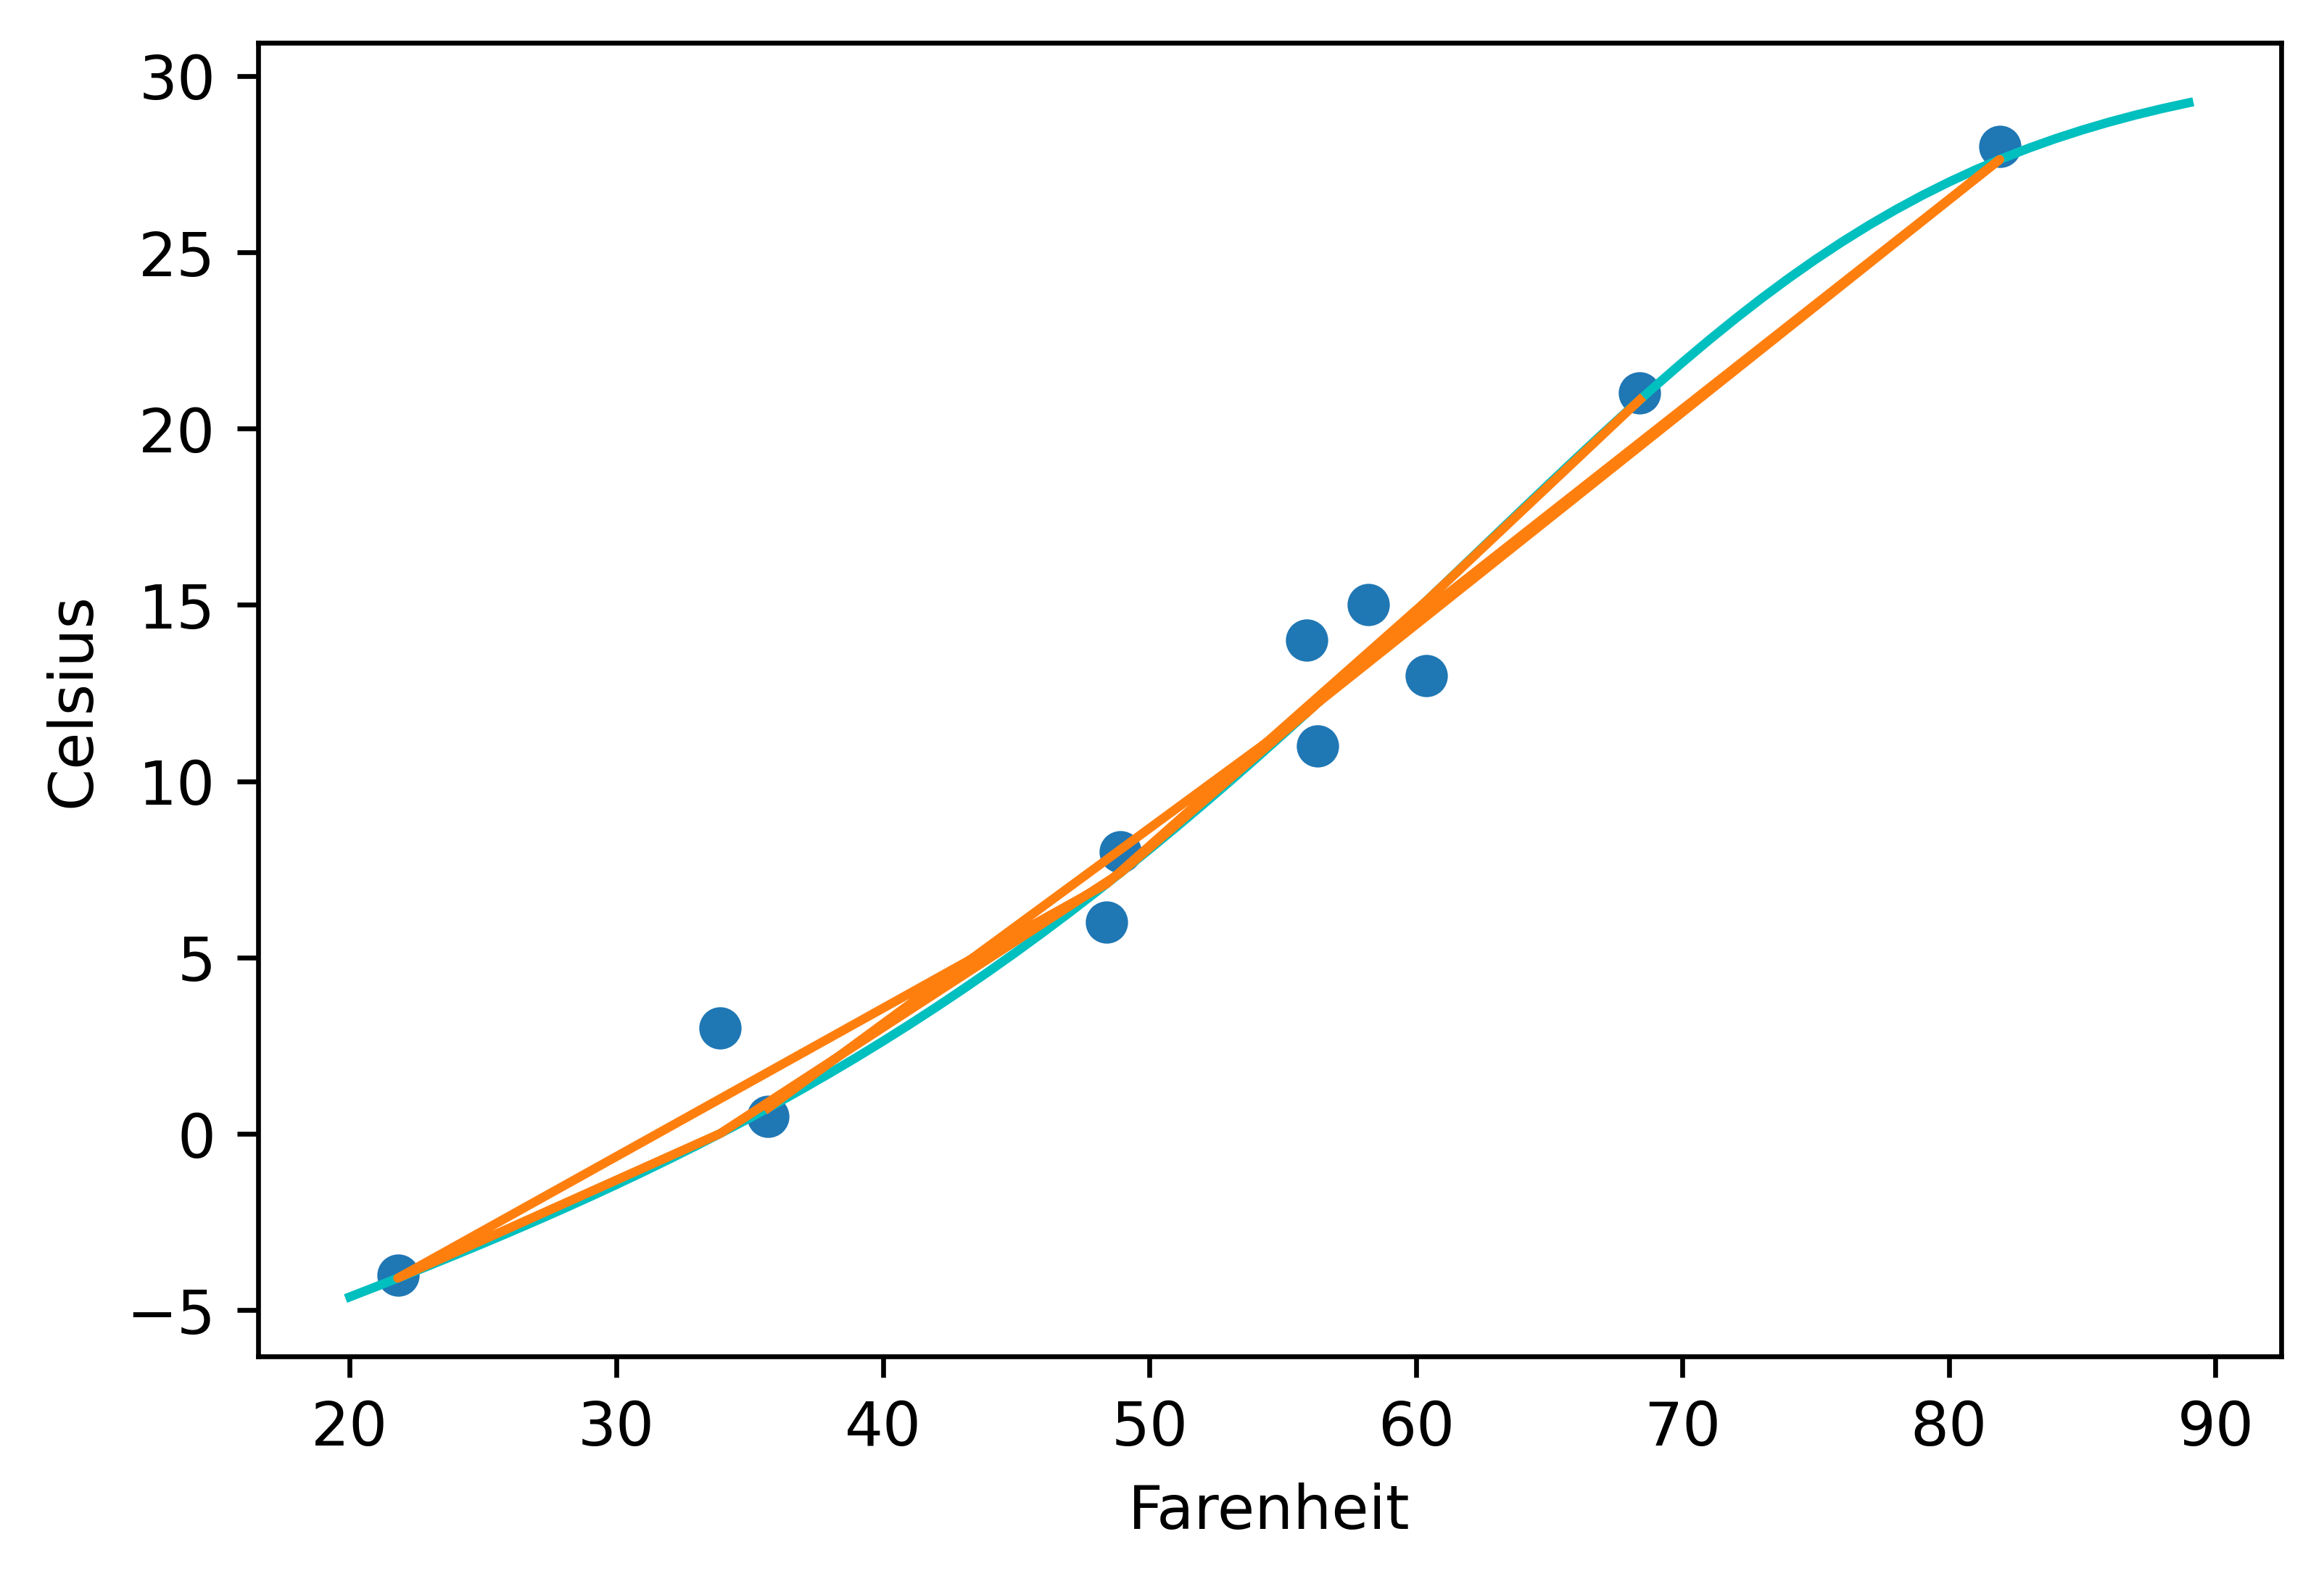

In [29]:
# Evaluate the model on all data and see how it differs from a line (from the linear model)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Farenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy())

## Exercises

In [30]:
# Creating a sequential model for the wine dataset

import pandas as pd

# Load data
wine_path = "../data/p1ch4/tabular-wine/winequality-white.csv"
wineq_df = pd.read_csv(wine_path, delimiter=";")

wineq_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [31]:
wineq = torch.from_numpy(wineq_df.values)
wineq

tensor([[ 7.0000,  0.2700,  0.3600,  ...,  0.4500,  8.8000,  6.0000],
        [ 6.3000,  0.3000,  0.3400,  ...,  0.4900,  9.5000,  6.0000],
        [ 8.1000,  0.2800,  0.4000,  ...,  0.4400, 10.1000,  6.0000],
        ...,
        [ 6.5000,  0.2400,  0.1900,  ...,  0.4600,  9.4000,  6.0000],
        [ 5.5000,  0.2900,  0.3000,  ...,  0.3800, 12.8000,  7.0000],
        [ 6.0000,  0.2100,  0.3800,  ...,  0.3200, 11.8000,  6.0000]],
       dtype=torch.float64)

In [32]:
target = wineq[:, -1] # Selects all rows and the last column
target

tensor([6., 6., 6.,  ..., 6., 7., 6.], dtype=torch.float64)

In [35]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(
    1, target.unsqueeze(1).type(torch.int64), 1.0
) # trailing underscore == in place operation

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])